# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
!pip install -U seaborn
!pip install hyperopt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 288 kB 4.8 MB/s eta 0:00:01
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.6 MB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 200 kB 44.7 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
import seaborn as sns
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [3]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

In [4]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      143424 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    143424 non-null  object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                143424 non-null  object
 11  medical_specialty         143424 non-null  object
 12  primary_diagnosis_code    143424 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

There are no null values. But "?" is used. 
We will replace all "?" by null. 

In [6]:
df = df.replace('?', np.nan)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143424 entries, 0 to 143423
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              143424 non-null  int64 
 1   patient_nbr               143424 non-null  int64 
 2   race                      140115 non-null  object
 3   gender                    143424 non-null  object
 4   age                       143424 non-null  object
 5   weight                    4302 non-null    object
 6   admission_type_id         143424 non-null  int64 
 7   discharge_disposition_id  143424 non-null  int64 
 8   admission_source_id       143424 non-null  int64 
 9   time_in_hospital          143424 non-null  int64 
 10  payer_code                89234 non-null   object
 11  medical_specialty         73961 non-null   object
 12  primary_diagnosis_code    143391 non-null  object
 13  other_diagnosis_codes     143424 non-null  object
 14  numb

In [8]:
df.max_glu_serum.unique()

array(['None', '>300', 'Norm', '>200'], dtype=object)

#### Null values analysis 
* Fields with an amount of missing/null values are: weight, payer_code, medical_speciality, number_outpatients, number_inpatients, number_emergency, num_procedures, ndc_codes.
* The majority of 'weight' information is not available, only 4302/143424 are available.
* 'payer_code' has 89234 available values. It is a distinct feature for the patient that can be removed for the sake of anonymization.
* 'medical_specialty' also has a moderate amount of null values, and it may be useful information.

In [9]:
# Get number of unique encounter id's
df['encounter_id'].nunique()

101766

In [10]:
IDs_mapping = pd.read_csv('../data_schema_references/IDs_mapping.csv')
ndc_lookup_table = pd.read_csv('../data_schema_references/ndc_lookup_table.csv')
project_data_schema = pd.read_csv('../data_schema_references/project_data_schema.csv')

In [11]:
IDs_mapping #Categories of admission type 

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
...,...,...
62,22,Transfer from hospital inpt/same fac reslt in...
63,23,Born inside this hospital
64,24,Born outside this hospital
65,25,Transfer from Ambulatory Surgery Center


In [12]:
ndc_lookup_table.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [13]:
len(ndc_lookup_table)

269

In [14]:
project_data_schema

,Feature Name\n,Type,Description
0,encounter_id,numeric ID\n,Unique identifier of an encounter
1,patient_nbr,numeric ID\n,Unique identifier of a patient
2,race,categorical,"Values: Caucasian, Asian, African American, Hi..."
3,gender,categorical,"Values: male, female, and unknown/invalid"
4,age,bucketed numerical feature (converted to categ...,"Grouped in 10-year intervals: [0, 10), [10, 20..."
5,weight,numerical,Weight in pounds.
6,admission_type_id,categorical,Integer identifier corresponding to 9 distinct...
7,discharge_disposition_id,categorical,Integer identifier corresponding to 29 distinc...
8,admission_source_id,categorical,nteger identifier corresponding to 21 distinct...
9,time_in_hospital,numerical,Integer number of days between admission and d...


## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [15]:
len(df.patient_nbr.unique())

71518

In [16]:
len(df)

143424

In [17]:
# Line Test
try:
    assert len(df) > df['encounter_id'].nunique() 
    print("Dataset could be at the line level")
except:
    print("Dataset is not at the line level")

Dataset could be at the line level


Student Response: Based on the finding that the total number of lines > number of unique encounters, the dataset is at the line level.

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

##### Numerical Features Analysis 

In [18]:
num_fields = project_data_schema[project_data_schema.Type.str.contains('numerical')]["Feature Name\n"].values
num_fields

array(['age', 'weight', 'time_in_hospital', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures'],
      dtype=object)

In [19]:
numeric = np.array([num for num in df.columns if df[num].dtype == "int64"])
numeric

array(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'number_outpatient', 'number_inpatient',
       'number_emergency', 'num_lab_procedures', 'number_diagnoses',
       'num_medications', 'num_procedures'], dtype='<U24')

In [20]:
num_fields = np.intersect1d(num_fields, numeric)

In [21]:
num_fields

array(['num_lab_procedures', 'num_medications', 'num_procedures',
       'number_diagnoses', 'number_emergency', 'number_inpatient',
       'number_outpatient', 'time_in_hospital'], dtype=object)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


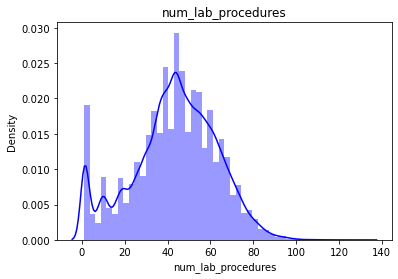

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


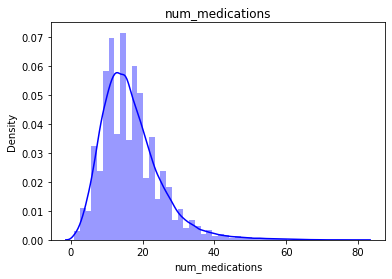

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


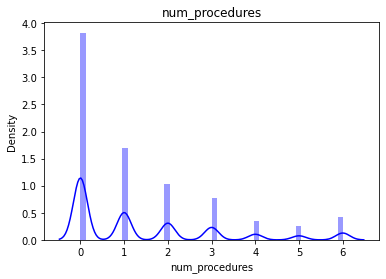

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


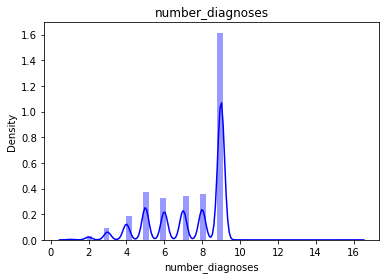

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


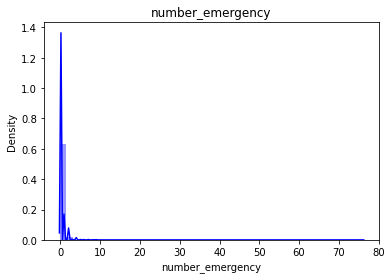

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


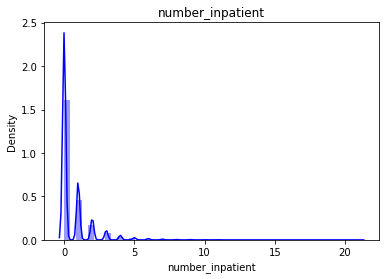

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


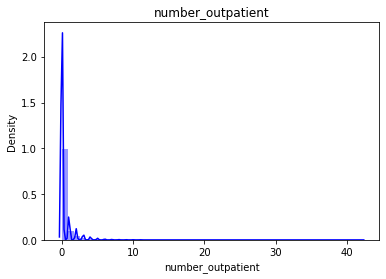

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


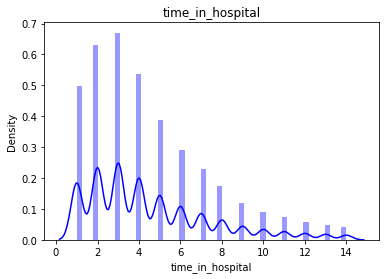

In [22]:
for num in num_fields:
    sns.distplot(df[num], kde=True, color = 'blue')
    plt.title(num)
    plt.show()

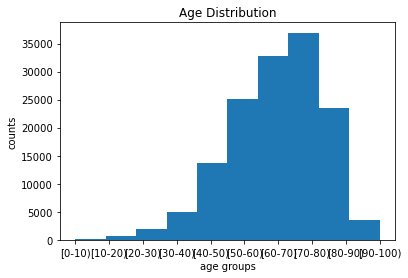

[70-80)     36928
[60-70)     32741
[50-60)     25095
[80-90)     23527
[40-50)     13729
[30-40)      4964
[90-100)     3619
[20-30)      1927
[10-20)       733
[0-10)        161
Name: age, dtype: int64

In [23]:
# age is categorical because it is structured in ranges 
plt.hist(df['age'].dropna(),bins = 10)
plt.title('Age Distribution')
plt.ylabel('counts')
plt.xlabel('age groups')
plt.show()
df['age'].value_counts()

##### Categorical features analysis 

In [24]:
cat_fields = list(df.select_dtypes(['object']).columns)
cat_fields

['race',
 'gender',
 'age',
 'weight',
 'payer_code',
 'medical_specialty',
 'primary_diagnosis_code',
 'other_diagnosis_codes',
 'ndc_code',
 'max_glu_serum',
 'A1Cresult',
 'change',
 'readmitted']

In [25]:
val_df = pd.DataFrame({'columns': df[cat_fields].columns, 
                           'cardinality': df[cat_fields].nunique() } )
val_df

,columns,cardinality
race,race,5
gender,gender,3
age,age,10
weight,weight,9
payer_code,payer_code,17
medical_specialty,medical_specialty,72
primary_diagnosis_code,primary_diagnosis_code,716
other_diagnosis_codes,other_diagnosis_codes,19374
ndc_code,ndc_code,251
max_glu_serum,max_glu_serum,4


In [26]:
len(df)

143424

In [27]:
df


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143419,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,38,590|296,1,0,0,53,13,9,0,47918-902,None,None,Ch,NO
143420,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0049-4110,None,None,Ch,NO
143421,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0781-5421,None,None,Ch,NO
143422,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,47918-902,None,None,Ch,NO


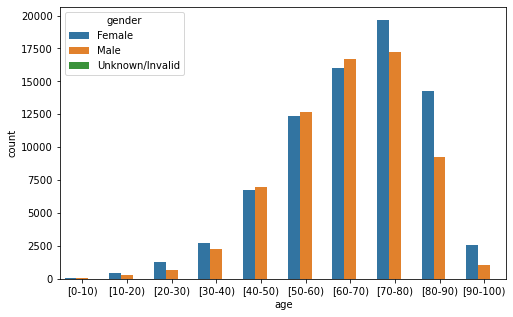

In [28]:
plt.figure(figsize=(8, 5))
sns.countplot(x = 'age', hue = 'gender', data = df)

**Student Response**: 

a. Fields with a high amount of missing/null values are: weight, payer_code, medical_speciality.

b. Numerical features with approximately Gaussian distributions are 'num_lab_procedures', and 'num_medications'.

c. Based on val_df, medical_specialty (72) primary_diagnosis_code (716), other_diagnosis_codes(19374) and ndc_code(251) are the categorical variables with high cardinality.

d. Demographic distributions in the dataset for the age and gender fields:
* The age distribution seems to skewed right with a peak on ages between 70-80. Regardless of the gender, we still have a similar trend. 
* The gender distribution looks roughly uniform. We discount the number of unknown gender. 


In [29]:
######NOTE: The visualization will only display in Chrome browser. ########
#full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
#tfdv.visualize_statistics(full_data_stats)

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [30]:
len(df)

143424

In [31]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [32]:
ndc_code_df.head()

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug


In [33]:
from student_utils import reduce_dimension_ndc

In [34]:
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [35]:
reduce_dim_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Novolin R
1,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,Novolin R
2,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO,Novolin R
3,15738,63555939,Caucasian,Female,[90-100),NaN,3,3,4,12,NaN,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,Novolin R
4,28236,89869032,AfricanAmerican,Female,[40-50),NaN,1,1,7,9,NaN,NaN,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,Novolin R


In [36]:
len(reduce_dim_df)

120020

In [37]:
#Spot Check a few ndc_code matches
ndc_code_df['Non-proprietary Name'][ndc_code_df['NDC_Code']=='68071-1701'].values[0]

'Human Insulin'

In [38]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [39]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [40]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:56133
Number of unique encounters:56133
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [41]:
first_encounter_df['patient_nbr'].nunique()

56133

In [42]:
len(first_encounter_df)

86954

In [43]:
first_encounter_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name
0,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,Novolin R
1,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,Novolin R
2,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,68071-1701,None,None,Ch,NO,Novolin R
3,15738,63555939,Caucasian,Female,[90-100),NaN,3,3,4,12,NaN,InternalMedicine,434,198|486,0,0,0,33,8,18,3,68071-1701,None,None,Ch,NO,Novolin R
4,28236,89869032,AfricanAmerican,Female,[40-50),NaN,1,1,7,9,NaN,NaN,250.7,403|996,0,0,0,47,9,17,2,68071-1701,None,None,No,>30,Novolin R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120014,268305450,110071008,Asian,Male,[50-60),NaN,1,1,7,5,NaN,InternalMedicine,47,276|584,0,0,0,49,9,28,2,49884-984,None,None,No,NO,Nateglinide
120016,254292852,100438128,Caucasian,Male,[60-70),NaN,2,6,7,7,MC,Emergency/Trauma,38,276|707,1,0,0,76,9,19,2,0781-5635,None,None,Ch,NO,Pioglitazone Hydrochloride And Glimepiride
120017,254292852,100438128,Caucasian,Male,[60-70),NaN,2,6,7,7,MC,Emergency/Trauma,38,276|707,1,0,0,76,9,19,2,0781-5635,None,None,Ch,NO,Pioglitazone Hydrochloride And Glimepiride
120018,403720562,41348115,Caucasian,Female,[60-70),NaN,3,3,1,6,CP,Radiologist,715,250|272,0,0,0,23,4,20,1,33342-177,None,None,Ch,NO,Pioglitazole And Metformin Hydrochloride


In [44]:
exclusion_list = ['generic_drug_name','ndc_code', "weight"]
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
grouping_field_list

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'primary_diagnosis_code',
 'other_diagnosis_codes',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures',
 'max_glu_serum',
 'A1Cresult',
 'change',
 'readmitted']

In [45]:
first_encounter_df.patient_nbr.nunique()

56133

In [46]:
from utils import * 

In [47]:
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient', 'number_inpatient', 'number_emergency', 'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures', 'max_glu_serum', 'A1Cresult', 'change', 'readmitted', 'generic_drug_name_array', 'Acarbose', 'Afrezza', 'Amaryl', 'Avandia_2MG', 'Avandia_4MG', 'Glimepiride', 'Glipizide', 'Glipizide_And_Metformin_Hydrochloride', 'Glucophage', 'Glucophage_XR', 'Glucotrol', 'Glucotrol_XL', 'Glyburide', 'Glyburide_And_Metformin_Hydrochloride', 'Glyburide-metformin_Hydrochloride', 'Glynase', 'Glyset', 'Humulin_R', 'Metformin_Hcl', 'Metformin_Hydrochloride', 'Metformin_Hydrochloride_Extended_Release', 'Miglitol', 'Nateglinide', 'Novolin_R', 'Pioglitazole_And_Metformin_Hydrochloride', 'Pioglitazone', 'Pioglitazone_Hydrochloride_And_Glimepi

In [48]:
len(ndc_col_list)

33

In [49]:
len(agg_drug_df)

14901

In [50]:
agg_drug_df['patient_nbr'].nunique()

14901

In [51]:
agg_drug_df['encounter_id'].nunique()

14901

In [52]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

In [53]:
agg_drug_df

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,max_glu_serum,A1Cresult,change,readmitted,generic_drug_name_array,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide
0,72091308,20123568,Caucasian,Female,[70-80),1,22,7,7,MC,Orthopedics-Reconstructive,821,276|285,0,0,0,58,9,15,2,None,None,Ch,NO,"[Afrezza, Pioglitazone]",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,72848634,20377854,Caucasian,Female,[60-70),2,1,1,3,MC,Nephrology,V56,403|599,0,0,0,59,6,11,3,None,None,No,NO,[Afrezza],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,73062156,20408121,Caucasian,Female,[90-100),1,1,7,4,MC,Emergency/Trauma,532,428|535,0,0,0,56,6,9,1,None,None,No,NO,[Glimepiride],0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,73731852,20542797,Caucasian,Male,[70-80),1,2,7,10,MC,InternalMedicine,682,427|276,0,0,0,68,6,18,1,None,None,Ch,NO,"[Afrezza, Glucophage]",0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,81355914,7239654,Caucasian,Female,[70-80),1,3,6,12,UN,InternalMedicine,238,250.02|733,0,0,0,77,5,19,5,None,>8,No,NO,[Afrezza],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14896,443207210,30370995,Other,Female,[30-40),2,1,7,3,MD,Emergency/Trauma,780,780|250,0,0,0,30,9,10,1,None,None,Ch,NO,"[Afrezza, Metformin Hydrochloride]",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
14897,443237558,93806559,Other,Male,[70-80),2,3,7,8,SP,Emergency/Trauma,574,250.5|276,0,0,1,67,9,35,3,None,None,Ch,NO,[Afrezza],0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14898,443266892,180189752,Caucasian,Male,[50-60),2,1,7,5,BC,Family/GeneralPractice,584,276|276,0,0,0,71,9,23,5,None,>7,Ch,>30,"[Novolin R, Glimepiride, Pioglitazone]",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
14899,443804570,33230016,Caucasian,Female,[70-80),1,22,7,8,MC,InternalMedicine,410,311|250,0,0,0,51,9,19,6,None,>7,No,>30,[Novolin R],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response: From cells above, weight field a lot of missing values so we will exclude it from the selected features. For payer_code, it also has 54190 missing value and it not much affect on our training process and it does not have a high correlation with the target variable. 

In [54]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']

student_categorical_col_list = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', "primary_diagnosis_code"] + required_demo_col_list + ndc_col_list
student_numerical_col_list = ['num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']

PREDICTOR_FIELD = 'time_in_hospital'

In [55]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [56]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [57]:
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [58]:
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

train size :  8941
remaining_size :  2980
Total number of unique patients are =  14901
Total number of unique patients in train =  8941
Total number of unique patients in validation =  2980
Total number of unique patients in test =  2980
Training partition has a shape =  (8941, 46)
Training partition has a shape =  (2980, 46)
Test partition has a shape =  (2980, 46)


In [59]:
d_train

,patient_nbr,time_in_hospital,admission_type_id,discharge_disposition_id,admission_source_id,primary_diagnosis_code,race,gender,age,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,num_lab_procedures,number_diagnoses,num_medications,num_procedures
0,11677005,4.0,2,1,1,250.42,Caucasian,Male,[50-60),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,62,5,6,0
1,36192159,5.0,1,3,7,435,Caucasian,Female,[70-80),0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,65,9,12,1
2,24402600,2.0,1,1,7,414,Caucasian,Male,[40-50),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,43,6,20,3
3,54564291,4.0,1,22,7,820,Caucasian,Male,[80-90),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,9,16,1
4,63002484,4.0,1,1,7,996,Caucasian,Male,[60-70),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,73,9,18,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8936,24430419,2.0,3,1,1,174,AfricanAmerican,Female,[60-70),0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,4,18,2
8937,67807854,2.0,1,1,7,428,Caucasian,Female,[60-70),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,64,8,15,0
8938,38752182,12.0,1,1,7,518,Caucasian,Female,[70-80),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77,9,32,1
8939,2023110,2.0,1,1,7,414,Caucasian,Female,[70-80),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,53,6,8,3


In [60]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [61]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0     2141
2.0     2454
3.0     2674
4.0     2041
5.0     1451
6.0     1081
7.0      904
8.0      618
9.0      433
10.0     304
11.0     279
12.0     211
13.0     181
14.0     129
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


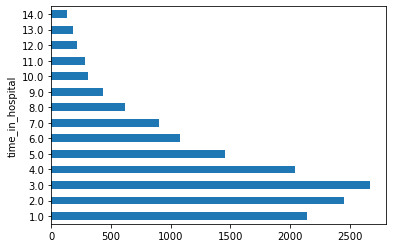

In [62]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     1294
2.0     1422
3.0     1653
4.0     1232
5.0      852
6.0      638
7.0      561
8.0      373
9.0      251
10.0     178
11.0     167
12.0     131
13.0     114
14.0      75
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


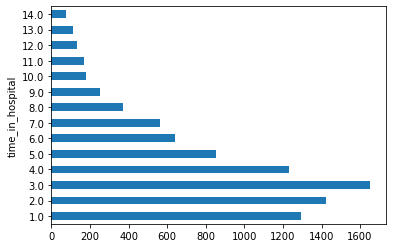

In [63]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0     431
2.0     512
3.0     512
4.0     407
5.0     303
6.0     227
7.0     161
8.0     118
9.0      97
10.0     65
11.0     51
12.0     43
13.0     27
14.0     26
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


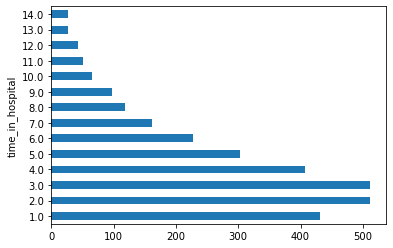

In [64]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female    7957
Male      6944
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


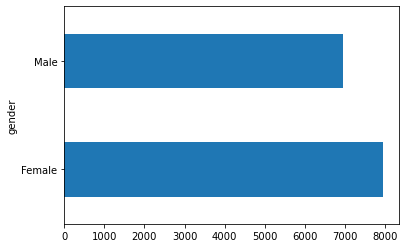

In [65]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    4775
Male      4166
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


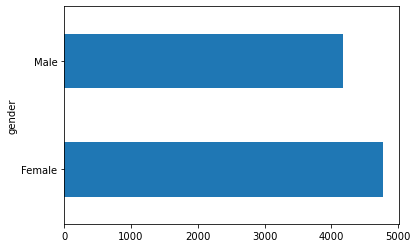

In [66]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    1573
Male      1407
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


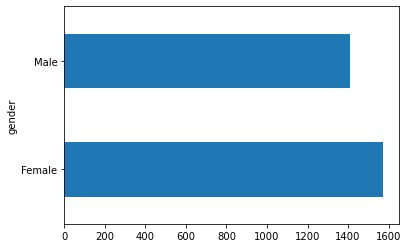

In [67]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [68]:
d_train

,patient_nbr,time_in_hospital,admission_type_id,discharge_disposition_id,admission_source_id,primary_diagnosis_code,race,gender,age,Acarbose,Afrezza,Amaryl,Avandia_2MG,Avandia_4MG,Glimepiride,Glipizide,Glipizide_And_Metformin_Hydrochloride,Glucophage,Glucophage_XR,Glucotrol,Glucotrol_XL,Glyburide,Glyburide_And_Metformin_Hydrochloride,Glyburide-metformin_Hydrochloride,Glynase,Glyset,Humulin_R,Metformin_Hcl,Metformin_Hydrochloride,Metformin_Hydrochloride_Extended_Release,Miglitol,Nateglinide,Novolin_R,Pioglitazole_And_Metformin_Hydrochloride,Pioglitazone,Pioglitazone_Hydrochloride_And_Glimepiride,Prandin,Repaglinide,Riomet,Riomet_Er,Starlix,Tolazamide,num_lab_procedures,number_diagnoses,num_medications,num_procedures
0,11677005,4.0,2,1,1,250.42,Caucasian,Male,[50-60),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,62,5,6,0
1,36192159,5.0,1,3,7,435,Caucasian,Female,[70-80),0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,65,9,12,1
2,24402600,2.0,1,1,7,414,Caucasian,Male,[40-50),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,43,6,20,3
3,54564291,4.0,1,22,7,820,Caucasian,Male,[80-90),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,9,16,1
4,63002484,4.0,1,1,7,996,Caucasian,Male,[60-70),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,73,9,18,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8936,24430419,2.0,3,1,1,174,AfricanAmerican,Female,[60-70),0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,4,18,2
8937,67807854,2.0,1,1,7,428,Caucasian,Female,[60-70),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,64,8,15,0
8938,38752182,12.0,1,1,7,518,Caucasian,Female,[70-80),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77,9,32,1
8939,2023110,2.0,1,1,7,414,Caucasian,Female,[70-80),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,53,6,8,3


In [69]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [70]:
diabetes_val_ds

<BatchDataset shapes: ({patient_nbr: (None,), admission_type_id: (None,), discharge_disposition_id: (None,), admission_source_id: (None,), primary_diagnosis_code: (None,), race: (None,), gender: (None,), age: (None,), Acarbose: (None,), Afrezza: (None,), Amaryl: (None,), Avandia_2MG: (None,), Avandia_4MG: (None,), Glimepiride: (None,), Glipizide: (None,), Glipizide_And_Metformin_Hydrochloride: (None,), Glucophage: (None,), Glucophage_XR: (None,), Glucotrol: (None,), Glucotrol_XL: (None,), Glyburide: (None,), Glyburide_And_Metformin_Hydrochloride: (None,), Glyburide-metformin_Hydrochloride: (None,), Glynase: (None,), Glyset: (None,), Humulin_R: (None,), Metformin_Hcl: (None,), Metformin_Hydrochloride: (None,), Metformin_Hydrochloride_Extended_Release: (None,), Miglitol: (None,), Nateglinide: (None,), Novolin_R: (None,), Pioglitazole_And_Metformin_Hydrochloride: (None,), Pioglitazone: (None,), Pioglitazone_Hydrochloride_And_Glimepiride: (None,), Prandin: (None,), Repaglinide: (None,), Ri

In [71]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
print(diabetes_batch)
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

{'patient_nbr': <tf.Tensor: shape=(128,), dtype=int32, numpy=
array([105121431,  89307648,     78408,    226440,  22425660,  24088500,
         5111064,  93919032,  71908173, 123812618,  80419230,  24493887,
        82879866, 123302993, 111362625, 100623699, 113467977,  94027644,
       138584435,  28347579,  23270094, 106746345,  41610420,  40892040,
        94512348,  41323356,  23287995,  80925966,  42793092,  60223509,
        88722801,  16015275,  24818796,  23405886,  33380154,  82269882,
        33062922,  72267075,  24490512, 103275270, 110116746,  25402761,
        64014966,  90388575,  18771660,  87209523,   9649035,  48385467,
        49763079,  57617775,  85702347, 103194351,  43991019,  41466114,
       138148286,  32952897,  24826500, 125011760,  79694469,  16012431,
        58417371,  23272866,  51834609,  88816401, 141528569, 104369319,
       109193778,  83341683,  24539292,  18652572,  25174899,  24558714,
        98758278,  42434226,  90131868,  24468183,  24118614, 

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [72]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [73]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

INFO:tensorflow:vocabulary_size = 6 in admission_type_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_type_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 21 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/discharge_disposition_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 12 in admission_source_id is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/admission_source_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 454 in primary_diagnosis_code is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/primary_diagnosis_code_vocab.txt.
INFO:tensorflow:vocabulary_size = 6 in race is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./diabetes_vocab/gender_vocab.txt.
INFO:tensorflow:voca

In [74]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_type_id', vocabulary_file='./diabetes_vocab/admission_type_id_vocab.txt', vocabulary_size=6, num_oov_buckets=1, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0.

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [75]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [76]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [77]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [78]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7f3e701eae60>, mean=41.21216866122358, std=20.449929346977765))

tf.Tensor(
[[-0.8 ]
 [ 1.35]
 [ 0.8 ]
 [-0.7 ]
 [ 0.2 ]
 [ 0.3 ]
 [ 1.25]
 [ 0.9 ]
 [-1.6 ]
 [ 1.4 ]
 [-0.5 ]
 [-0.75]
 [-1.5 ]
 [ 2.3 ]
 [-0.2 ]
 [-2.  ]
 [ 1.1 ]
 [-0.75]
 [ 0.2 ]
 [ 1.8 ]
 [-0.25]
 [ 0.6 ]
 [ 0.75]
 [ 0.1 ]
 [ 1.15]
 [ 0.  ]
 [ 1.05]
 [ 0.1 ]
 [ 0.15]
 [-0.1 ]
 [-0.65]
 [ 0.75]
 [ 0.4 ]
 [-1.4 ]
 [ 0.95]
 [ 2.15]
 [-0.45]
 [ 1.1 ]
 [ 0.1 ]
 [-0.25]
 [-0.15]
 [-0.65]
 [ 0.35]
 [-0.25]
 [ 1.75]
 [ 0.2 ]
 [ 0.5 ]
 [-1.1 ]
 [-1.85]
 [-0.2 ]
 [-0.8 ]
 [ 1.4 ]
 [ 0.05]
 [ 0.55]
 [ 0.85]
 [ 1.2 ]
 [ 0.55]
 [ 0.7 ]
 [ 0.35]
 [ 1.1 ]
 [-0.2 ]
 [ 0.  ]
 [ 0.75]
 [ 1.15]
 [-1.55]
 [ 1.4 ]
 [ 1.25]
 [ 0.8 ]
 [-0.75]
 [ 0.5 ]
 [-0.2 ]
 [-0.2 ]
 [ 1.15]
 [ 0.6 ]
 [ 0.55]
 [ 0.95]
 [-1.25]
 [-0.7 ]
 [ 0.6 ]
 [ 1.3 ]
 [-0.5 ]
 [

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [79]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [80]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [81]:
space = {
            'units1': hp.choice('units1',[64, 128, 150, 224, 256]),
            'units2': hp.choice('units2',[64, 128, 150, 224, 256]),
            'units3': hp.choice('units3',[64, 128, 150, 224, 256]),

            'dropout1': hp.uniform('dropout1', .25,.75),
            'dropout2': hp.uniform('dropout2',  .25,.75),

            'batch_size' : hp.uniform('batch_size', 28,128),

            'nb_epochs' :  100,
            'optimizer': hp.choice('optimizer',['adadelta','adam','rmsprop']),
            'activation': 'relu'
        }

In [82]:
def build_sequential_model(params):
    claim_feature_columns = tf_cat_col_list + tf_cont_col_list
    claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)
    model = tf.keras.Sequential([
        claim_feature_layer,
        tf.keras.layers.Dense(params['units1'], activation='relu'),
        #tf.keras.layers.Dropout(params['dropout1']),
        tf.keras.layers.Dense(params['units2'], activation='relu'),
        tf.keras.layers.Dense(params['units3'], activation='relu'),
        #tf.keras.layers.Dropout(params['dropout1']),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(params, epochs=5, loss_metric='mse'):
    model = build_sequential_model(params)
    train_ds, val_ds = data()
    model.compile(optimizer=params['optimizer'], loss=loss_metric, metrics=[loss_metric])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=10)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return {"loss": history.history['val_loss'][-1], 'history': history, "model":model, 'status': STATUS_OK}

In [83]:
claim_feature_layer

In [84]:
diabetes_train_ds

<BatchDataset shapes: ({patient_nbr: (None,), admission_type_id: (None,), discharge_disposition_id: (None,), admission_source_id: (None,), primary_diagnosis_code: (None,), race: (None,), gender: (None,), age: (None,), Acarbose: (None,), Afrezza: (None,), Amaryl: (None,), Avandia_2MG: (None,), Avandia_4MG: (None,), Glimepiride: (None,), Glipizide: (None,), Glipizide_And_Metformin_Hydrochloride: (None,), Glucophage: (None,), Glucophage_XR: (None,), Glucotrol: (None,), Glucotrol_XL: (None,), Glyburide: (None,), Glyburide_And_Metformin_Hydrochloride: (None,), Glyburide-metformin_Hydrochloride: (None,), Glynase: (None,), Glyset: (None,), Humulin_R: (None,), Metformin_Hcl: (None,), Metformin_Hydrochloride: (None,), Metformin_Hydrochloride_Extended_Release: (None,), Miglitol: (None,), Nateglinide: (None,), Novolin_R: (None,), Pioglitazole_And_Metformin_Hydrochloride: (None,), Pioglitazone: (None,), Pioglitazone_Hydrochloride_And_Glimepiride: (None,), Prandin: (None,), Repaglinide: (None,), Ri

In [85]:
def data():
    return diabetes_train_ds, diabetes_val_ds

In [86]:
trials = Trials()

In [87]:
best = fmin(build_diabetes_model, space, algo=tpe.suggest, max_evals=5, trials=trials)
print('best: ', best)

Train for 70 steps, validate for 24 steps            
Epoch 1/5                                            
 1/70 [..............................]               
 - ETA: 4:24 - loss: 55.1794 - mse: 55.1792          
                                                     
 3/70 [>.............................]               
 - ETA: 1:27 - loss: 38.3671 - mse: 38.4112          
                                                     
 5/70 [=>............................]               
 - ETA: 51s - loss: 29.9341 - mse: 30.0727           
                                                    
 6/70 [=>............................]               
 - ETA: 42s - loss: 27.0106 - mse: 27.0963           
                                                    
 8/70 [==>...........................]               
 - ETA: 31s - loss: 27.0115 - mse: 27.0451           
                                                    
10/70 [===>..........................]               
 - ETA: 24s - loss: 29.0537 - m

                                                     
27/70 [==========>...................]               
 - ETA: 1s - loss: 32.7369 - mse: 32.7747            
                                                     
29/70 [===========>..................]               
 - ETA: 1s - loss: 35.0862 - mse: 35.1575            
                                                     
31/70 [============>.................]               
 - ETA: 1s - loss: 35.2156 - mse: 35.3280            
                                                     
33/70 [=============>................]               
 - ETA: 1s - loss: 33.9447 - mse: 33.9964            
                                                     
35/70 [==============>...............]               
 - ETA: 1s - loss: 32.7434 - mse: 32.7527            
                                                     
37/70 [==============>...............]               
 - ETA: 1s - loss: 32.5676 - mse: 32.5758            
                            

53/70 [=====================>........]               
 - ETA: 0s - loss: 20.8604 - mse: 20.3331            
                                                     
55/70 [======================>.......]               
 - ETA: 0s - loss: 20.4399 - mse: 19.8789            
                                                     
57/70 [=======================>......]               
 - ETA: 0s - loss: 20.5270 - mse: 19.9912            
                                                     
59/70 [========================>.....]               
 - ETA: 0s - loss: 20.2036 - mse: 19.6517            
                                                     
61/70 [=========================>....]               
 - ETA: 0s - loss: 19.8058 - mse: 19.2149            
                                                     
63/70 [==========================>...]               
 - ETA: 0s - loss: 19.7310 - mse: 19.1453            
                                                     
65/70 [=====================

 5/70 [=>............................]               
 - ETA: 5s - loss: 21.3979 - mse: 20.1887            
                                                     
 7/70 [==>...........................]               
 - ETA: 4s - loss: 20.8596 - mse: 19.2899            
                                                     
 9/70 [==>...........................]               
 - ETA: 3s - loss: 20.1872 - mse: 18.8765            
                                                     
11/70 [===>..........................]               
 - ETA: 3s - loss: 18.5043 - mse: 17.2868            
                                                     
12/70 [====>.........................]               
 - ETA: 3s - loss: 20.2231 - mse: 19.0659            
                                                     
14/70 [=====>........................]               
 - ETA: 2s - loss: 18.8340 - mse: 17.7867            
                                                     
16/70 [=====>...............

18/70 [======>.......................]                                         
 - ETA: 11s - loss: 39.2154 - mse: 39.2054                                     
                                                                              
20/70 [=======>......................]                                         
 - ETA: 10s - loss: 38.7761 - mse: 38.7584                                     
                                                                              
22/70 [========>.....................]                                         
 - ETA: 8s - loss: 37.7551 - mse: 37.7328                                      
                                                                               
24/70 [=========>....................]                                         
 - ETA: 8s - loss: 37.7800 - mse: 37.7568                                      
                                                                               
26/70 [==========>...................]    

14/70 [=====>........................]                                         
 - ETA: 2s - loss: 25.6959 - mse: 25.5654                                      
                                                                               
16/70 [=====>........................]                                         
 - ETA: 2s - loss: 25.1860 - mse: 25.0466                                      
                                                                               
18/70 [======>.......................]                                         
 - ETA: 2s - loss: 26.3676 - mse: 26.2433                                      
                                                                               
20/70 [=======>......................]                                         
 - ETA: 2s - loss: 25.3749 - mse: 25.2696                                      
                                                                               
22/70 [========>.....................]  

 9/70 [==>...........................]                                         
 - ETA: 3s - loss: 35.1479 - mse: 35.1479                                      
                                                                               
11/70 [===>..........................]                                         
 - ETA: 3s - loss: 33.8301 - mse: 33.8775                                      
                                                                               
13/70 [====>.........................]                                         
 - ETA: 3s - loss: 31.6174 - mse: 31.5813                                      
                                                                               
15/70 [=====>........................]                                         
 - ETA: 2s - loss: 30.8874 - mse: 30.8408                                      
                                                                               
17/70 [======>.......................]  

70/70 [==============================]                                         
 - 3s 50ms/step - loss: 28.1746 - mse: 28.1758 - val_loss: 20.8495 - val_mse: 20.8654

Epoch 4/5                                                                      
 1/70 [..............................]                                         
 - ETA: 19s - loss: 38.2545 - mse: 38.7047                                     
                                                                              
 3/70 [>.............................]                                         
 - ETA: 7s - loss: 29.6880 - mse: 29.8704                                      
                                                                               
 5/70 [=>............................]                                         
 - ETA: 5s - loss: 28.3964 - mse: 28.2739                                      
                                                                               
 7/70 [==>........................

62/70 [=========================>....]                                         
 - ETA: 0s - loss: 25.6136 - mse: 25.4032                                      
                                                                               
64/70 [==========================>...]                                         
 - ETA: 0s - loss: 25.6241 - mse: 25.4165                                      
                                                                               
66/70 [===========================>..]                                         
 - ETA: 0s - loss: 25.4994 - mse: 25.3001                                      
                                                                               
68/70 [============================>.]                                         
 - ETA: 0s - loss: 25.2803 - mse: 25.0655                                      
                                                                               
70/70 [==============================]  

58/70 [=======================>......]                                         
 - ETA: 0s - loss: 18.5784 - mse: 18.2143                                      
                                                                               
60/70 [========================>.....]                                         
 - ETA: 0s - loss: 18.6544 - mse: 18.3070                                      
                                                                               
62/70 [=========================>....]                                         
 - ETA: 0s - loss: 18.5143 - mse: 18.1664                                      
                                                                               
64/70 [==========================>...]                                         
 - ETA: 0s - loss: 19.1698 - mse: 18.8363                                      
                                                                               
66/70 [===========================>..]  

                                                                               
55/70 [======================>.......]                                         
 - ETA: 1s - loss: 37.4559 - mse: 37.4712                                      
                                                                               
57/70 [=======================>......]                                         
 - ETA: 1s - loss: 36.6928 - mse: 36.7025                                      
                                                                               
59/70 [========================>.....]                                         
 - ETA: 0s - loss: 35.9290 - mse: 35.9274                                      
                                                                               
61/70 [=========================>....]                                         
 - ETA: 0s - loss: 35.7513 - mse: 35.7569                                      
                                        

                                                                               
49/70 [====================>.........]                                         
 - ETA: 0s - loss: 29.2206 - mse: 29.1455                                      
                                                                               
51/70 [====================>.........]                                         
 - ETA: 0s - loss: 29.3150 - mse: 29.2303                                      
                                                                               
53/70 [=====================>........]                                         
 - ETA: 0s - loss: 28.6950 - mse: 28.5643                                      
                                                                               
55/70 [======================>.......]                                         
 - ETA: 0s - loss: 28.9108 - mse: 28.7636                                      
                                        

                                                                               
41/70 [================>.............]                                         
 - ETA: 1s - loss: 26.4163 - mse: 26.3161                                      
                                                                               
43/70 [=================>............]                                         
 - ETA: 1s - loss: 26.2074 - mse: 26.0739                                      
                                                                               
45/70 [==================>...........]                                         
 - ETA: 0s - loss: 27.1191 - mse: 27.0296                                      
                                                                               
46/70 [==================>...........]                                         
 - ETA: 0s - loss: 26.6954 - mse: 26.6050                                      
                                        

                                                                               
36/70 [==============>...............]                                         
 - ETA: 1s - loss: 19.9021 - mse: 19.4089                                      
                                                                               
38/70 [===============>..............]                                         
 - ETA: 1s - loss: 19.6997 - mse: 19.2163                                      
                                                                               
40/70 [================>.............]                                         
 - ETA: 1s - loss: 19.1957 - mse: 18.7000                                      
                                                                               
42/70 [=================>............]                                         
 - ETA: 1s - loss: 18.9396 - mse: 18.4376                                      
                                        

                                                                               
31/70 [============>.................]                                         
 - ETA: 1s - loss: 16.8103 - mse: 16.3600                                      
                                                                               
33/70 [=============>................]                                         
 - ETA: 1s - loss: 16.9269 - mse: 16.4879                                      
                                                                               
35/70 [==============>...............]                                         
 - ETA: 1s - loss: 17.9450 - mse: 17.5077                                      
                                                                               
37/70 [==============>...............]                                         
 - ETA: 1s - loss: 17.8919 - mse: 17.4258                                      
                                        

 - ETA: 8s - loss: 23.4698 - mse: 23.4129                                      
                                                                               
27/70 [==========>...................]                                         
 - ETA: 7s - loss: 24.4308 - mse: 24.3812                                      
                                                                               
28/70 [===========>..................]                                         
 - ETA: 6s - loss: 23.8765 - mse: 23.8229                                      
                                                                               
30/70 [===========>..................]                                         
 - ETA: 6s - loss: 23.0164 - mse: 22.9549                                      
                                                                               
32/70 [============>.................]                                         
 - ETA: 5s - loss: 27.7953 - mse: 27.745

 - ETA: 2s - loss: 25.2242 - mse: 25.0833                                      
                                                                               
23/70 [========>.....................]                                         
 - ETA: 2s - loss: 25.1130 - mse: 24.9734                                      
                                                                               
25/70 [=========>....................]                                         
 - ETA: 1s - loss: 25.2519 - mse: 25.1245                                      
                                                                               
27/70 [==========>...................]                                         
 - ETA: 1s - loss: 24.0835 - mse: 23.9390                                      
                                                                               
29/70 [===========>..................]                                         
 - ETA: 1s - loss: 24.0151 - mse: 23.864

 - ETA: 2s - loss: 23.0632 - mse: 22.8616                                      
                                                                               
19/70 [=======>......................]                                         
 - ETA: 2s - loss: 22.7342 - mse: 22.5078                                      
                                                                               
21/70 [========>.....................]                                         
 - ETA: 2s - loss: 22.1615 - mse: 21.9517                                      
                                                                               
23/70 [========>.....................]                                         
 - ETA: 2s - loss: 21.1093 - mse: 20.9051                                      
                                                                               
24/70 [=========>....................]                                         
 - ETA: 2s - loss: 20.5719 - mse: 20.362

 - ETA: 3s - loss: 25.2241 - mse: 25.1258                                      
                                                                               
11/70 [===>..........................]                                         
 - ETA: 3s - loss: 24.4667 - mse: 24.3818                                      
                                                                               
13/70 [====>.........................]                                         
 - ETA: 3s - loss: 23.8260 - mse: 23.6615                                      
                                                                               
15/70 [=====>........................]                                         
 - ETA: 2s - loss: 24.3260 - mse: 24.1404                                      
                                                                               
17/70 [======>.......................]                                         
 - ETA: 2s - loss: 23.5279 - mse: 23.328

 - ETA: 8s - loss: 10.6815 - mse: 10.3270                                      
                                                                               
 5/70 [=>............................]                                         
 - ETA: 5s - loss: 10.7981 - mse: 10.3457                                      
                                                                               
 7/70 [==>...........................]                                         
 - ETA: 4s - loss: 14.1681 - mse: 13.8852                                      
                                                                               
 9/70 [==>...........................]                                         
 - ETA: 3s - loss: 18.7864 - mse: 18.6295                                      
                                                                               
11/70 [===>..........................]                                         
 - ETA: 3s - loss: 17.9389 - mse: 17.551

 - ETA: 0s - loss: 25.8550 - mse: 25.6486                                      
                                                                               
70/70 [==============================]                                         
 - 3s 49ms/step - loss: 25.6934 - mse: 25.5070 - val_loss: 19.6531 - val_mse: 18.5746

Train for 70 steps, validate for 24 steps                                      
Epoch 1/5                                                                      
 1/70 [..............................]                                         
 - ETA: 3:48 - loss: 23.3089 - mse: 23.3088                                    
                                                                               
 3/70 [>.............................]                                         
 - ETA: 1:15 - loss: 22.6521 - mse: 22.6519                                    
                                                                               
 5/70 [=>........................

63/70 [==========================>...]                                         
 - ETA: 0s - loss: 34.9396 - mse: 34.9396                                      
                                                                               
65/70 [==========================>...]                                         
 - ETA: 0s - loss: 34.3696 - mse: 34.3696                                      
                                                                               
67/70 [===========================>..]                                         
 - ETA: 0s - loss: 34.4304 - mse: 34.4305                                      
                                                                               
69/70 [============================>.]                                         
 - ETA: 0s - loss: 34.5225 - mse: 34.5225                                      
                                                                               
70/70 [==============================]  

58/70 [=======================>......]                                         
 - ETA: 0s - loss: 31.0820 - mse: 31.0820                                      
                                                                               
60/70 [========================>.....]                                         
 - ETA: 0s - loss: 31.0320 - mse: 31.0319                                      
                                                                               
62/70 [=========================>....]                                         
 - ETA: 0s - loss: 31.0195 - mse: 31.0194                                      
                                                                               
64/70 [==========================>...]                                         
 - ETA: 0s - loss: 30.5000 - mse: 30.4998                                      
                                                                               
65/70 [==========================>...]  

53/70 [=====================>........]                                         
 - ETA: 0s - loss: 32.5614 - mse: 32.5611                                      
                                                                               
55/70 [======================>.......]                                         
 - ETA: 0s - loss: 33.7499 - mse: 33.7497                                      
                                                                               
57/70 [=======================>......]                                         
 - ETA: 0s - loss: 34.9123 - mse: 34.9122                                      
                                                                               
59/70 [========================>.....]                                         
 - ETA: 0s - loss: 34.8566 - mse: 34.8566                                      
                                                                               
61/70 [=========================>....]  

48/70 [===================>..........]                                         
 - ETA: 0s - loss: 33.7670 - mse: 33.7673                                      
                                                                               
50/70 [====================>.........]                                         
 - ETA: 0s - loss: 33.3244 - mse: 33.3245                                      
                                                                               
52/70 [=====================>........]                                         
 - ETA: 0s - loss: 32.9545 - mse: 32.9546                                      
                                                                               
54/70 [======================>.......]                                         
 - ETA: 0s - loss: 32.6008 - mse: 32.6009                                      
                                                                               
56/70 [=======================>......]  

43/70 [=================>............]                                         
 - ETA: 1s - loss: 35.1350 - mse: 35.1354                                      
                                                                               
45/70 [==================>...........]                                         
 - ETA: 0s - loss: 37.7872 - mse: 37.7878                                      
                                                                               
47/70 [===================>..........]                                         
 - ETA: 0s - loss: 37.5508 - mse: 37.5513                                      
                                                                               
49/70 [====================>.........]                                         
 - ETA: 0s - loss: 37.3069 - mse: 37.3075                                      
                                                                               
51/70 [====================>.........]  

In [88]:
best["optimizer"]

2

In [89]:
best["optimizer"] = 'adam'

In [90]:
diabetes_result = build_diabetes_model(best,  epochs=300)

Train for 70 steps, validate for 24 steps
Epoch 1/300
70/70 [==============================] - 7s 104ms/step - loss: 27.4447 - mse: 27.4522 - val_loss: 30.6934 - val_mse: 31.0751
Epoch 2/300
70/70 [==============================] - 3s 39ms/step - loss: 27.8987 - mse: 27.8664 - val_loss: 28.5153 - val_mse: 27.9660
Epoch 3/300
70/70 [==============================] - 3s 38ms/step - loss: 26.5129 - mse: 26.5057 - val_loss: 25.9039 - val_mse: 26.0643
Epoch 4/300
70/70 [==============================] - 3s 39ms/step - loss: 27.1545 - mse: 27.1104 - val_loss: 29.3576 - val_mse: 29.0199
Epoch 5/300
70/70 [==============================] - 3s 38ms/step - loss: 27.6739 - mse: 27.6882 - val_loss: 25.4928 - val_mse: 25.3067
Epoch 6/300
70/70 [==============================] - 3s 38ms/step - loss: 25.2100 - mse: 25.1385 - val_loss: 25.4759 - val_mse: 25.9117
Epoch 7/300
70/70 [==============================] - 3s 38ms/step - loss: 24.6302 - mse: 24.4944 - val_loss: 24.0825 - val_mse: 24.1685
Epoch

70/70 [==============================] - 3s 38ms/step - loss: 7.6987 - mse: 7.1914 - val_loss: 7.1386 - val_mse: 6.5298
Epoch 62/300
70/70 [==============================] - 3s 38ms/step - loss: 7.2939 - mse: 6.4450 - val_loss: 7.3731 - val_mse: 6.6221


## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [91]:
diabetes_model = diabetes_result["model"]

In [92]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

In [93]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [94]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [95]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,1.820721,13.0,8.890253,0.665664
1,1.822913,1.0,3.204523,0.681331
2,3.078553,5.0,3.605532,0.680218
3,2.428633,6.0,4.800552,0.676907
4,3.815305,5.0,5.241241,0.675689


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [96]:
a =prob_output_df["pred_mean"]
a.astype(int)
student_binary_prediction = a.apply(lambda x: 1 if x >= 1 else 0 )

In [97]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

In [100]:
prob_output_df

,pred,actual_value,pred_mean,pred_std
0,1.820721,13.0,8.890253,0.665664
1,1.822913,1.0,3.204523,0.681331
2,3.078553,5.0,3.605532,0.680218
3,2.428633,6.0,4.800552,0.676907
4,3.815305,5.0,5.241241,0.675689
...,...,...,...,...
2975,3.851563,7.0,6.106750,0.673302
2976,-0.376368,3.0,3.136947,0.681519
2977,3.417450,12.0,10.820916,0.660402
2978,2.693166,7.0,5.990149,0.673623


### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [101]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np 
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x > 5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

In [102]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,23507613,Male,AfricanAmerican,13.0,1,1
1,106311465,Male,Caucasian,1.0,0,0
2,23989986,Male,AfricanAmerican,5.0,0,0
3,139211510,Female,Asian,6.0,0,1
4,43280154,Male,Caucasian,5.0,1,0


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [103]:
# AUC, F1, precision and recall
from sklearn.metrics import confusion_matrix
print(confusion_matrix(pred_test_df['label_value'], pred_test_df['score']))

[[1704  461]
 [ 225  590]]


In [104]:
from sklearn.metrics import classification_report
print(classification_report(pred_test_df['label_value'], pred_test_df['score']))

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      2165
           1       0.56      0.72      0.63       815

    accuracy                           0.77      2980
   macro avg       0.72      0.76      0.73      2980
weighted avg       0.80      0.77      0.78      2980



# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [105]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)


model_id, score_thresholds 1 {'rank_abs': [1051]}


In [106]:
clean_xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,1,binary 0/1,1051,race,AfricanAmerican,0.720238,0.794643,0.116625,0.431925,0.205357,0.279762,0.883375,0.568075,213,403,0.202664,0.345779,92,47,356,121,168,448,616,2980,0.272727
1,1,binary 0/1,1051,race,Asian,0.583333,0.761905,0.238095,0.416667,0.238095,0.416667,0.761905,0.583333,12,21,0.011418,0.363636,5,5,16,7,12,21,33,2980,0.363636
2,1,binary 0/1,1051,race,Caucasian,0.733668,0.784070,0.112051,0.442038,0.215930,0.266332,0.887949,0.557962,785,1419,0.746908,0.356171,347,159,1260,438,597,1607,2204,2980,0.270871
3,1,binary 0/1,1051,race,Hispanic,0.555556,0.792453,0.160000,0.523810,0.207547,0.444444,0.840000,0.476190,21,50,0.019981,0.295775,11,8,42,10,18,53,71,2980,0.253521
4,1,binary 0/1,1051,race,Other,0.700000,0.833333,0.166667,0.300000,0.166667,0.300000,0.833333,0.700000,20,36,0.019029,0.357143,6,6,30,14,20,36,56,2980,0.357143
5,1,binary 0/1,1051,gender,Female,0.732484,0.759528,0.130841,0.434426,0.240472,0.267516,0.869159,0.565574,610,963,0.580400,0.387794,265,126,837,345,471,1102,1573,2980,0.299428
6,1,binary 0/1,1051,gender,Male,0.712209,0.815616,0.102484,0.444444,0.184384,0.287791,0.897516,0.555556,441,966,0.419600,0.313433,196,99,867,245,344,1063,1407,2980,0.244492


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [107]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

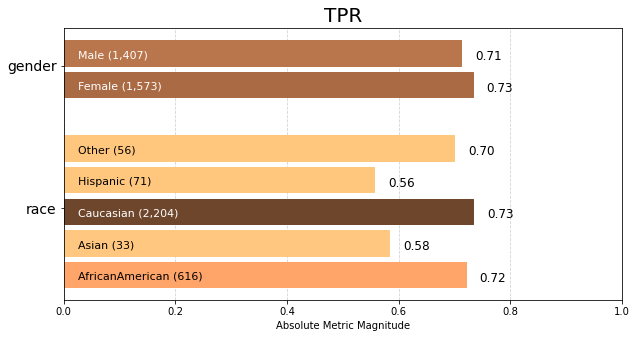

In [108]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?
tpr = aqp.plot_group_metric(clean_xtab, 'tpr')

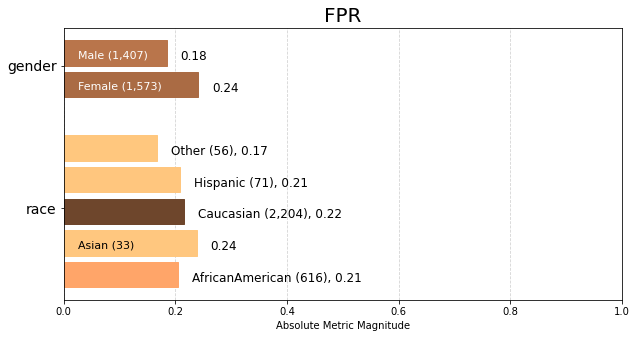

In [109]:
fpr = aqp.plot_group_metric(clean_xtab, 'fpr')

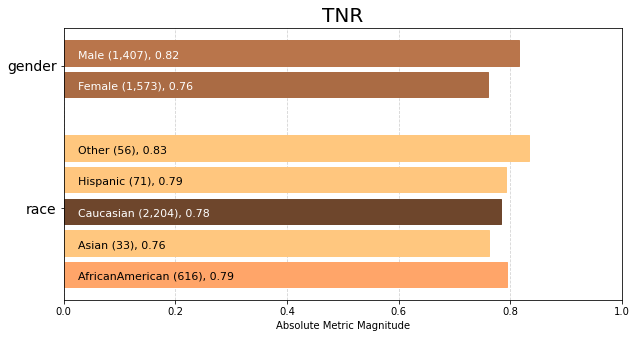

In [110]:
tnr = aqp.plot_group_metric(clean_xtab, 'tnr')

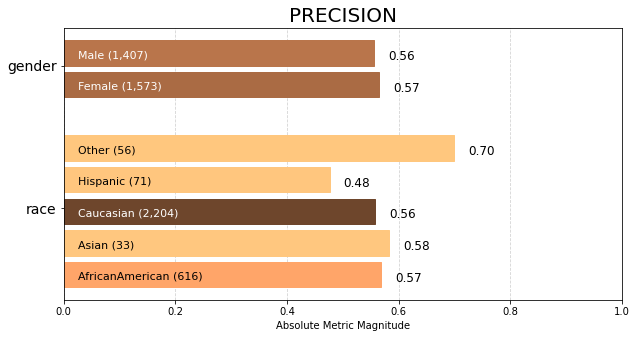

In [111]:
precision = aqp.plot_group_metric(clean_xtab, 'precision')

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

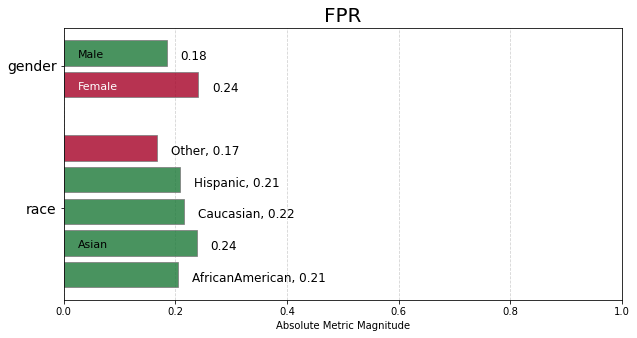

In [112]:
# Reference group fairness plot
fpr_fairness = aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)

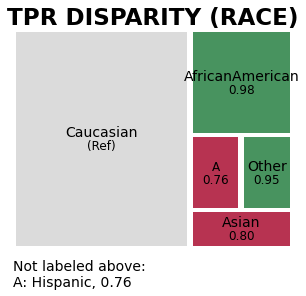

In [113]:
fpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tpr', attribute_name='race')

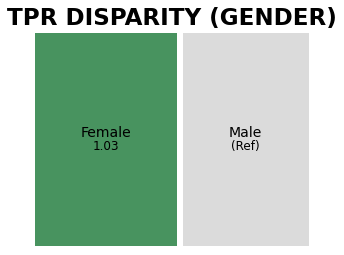

In [114]:
tpr_disparity_fairness = aqp.plot_fairness_disparity(fdf, group_metric='tpr', attribute_name='gender')

In [ ]:
%cd .. 
!zip -r code.zip directorytozip -x